# __SimpleNN__ (keras; mnist)

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

Дану нейромережу навчатимемо на датасеті `MNIST`. Цей датасет є великою кількістю зображень рукописних цифр розміром `28х28` пікселів. Кожен піксель набуває значення від 0 до 255.
<br>
Як і раніше датасет буде розділений на навчальну та тестову вибірки. При цьому виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилися у проміжку від 0 до 1, розділюючи яскравість кожного пікселя на 255.
<br>
Крім того, архітектура нейронної мережі очікує на вхід вектор. У даному випадку кожен об'єкт вибірки є матрицею. Тому "розтягнемо" матрицю `28x28`, до вектора, що складається з `784` елементів.

In [30]:
from collections import Counter
import os
import random
from typing import Optional, Union


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.datasets import mnist
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical


In [31]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [32]:
# hyperparameters+
cfg = {
       'learning_rate': 0.001,
       'training_steps': 3000,
       'batch_size': 256, # для перерахунку ваг не на всій вибірці
       'display_step': 100,
       'n_hidden_1': 128,
       'n_hidden_2': 256,
       'buffer_size': 5000,
       }

buffer_size=5000 This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements.

In [33]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# int convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

In [34]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
# cfg['num_classes'] = len(set(np.concatenate((y_train, y_test), axis=0)))

In [35]:
num_classes = Counter(y_train)
num_classes

Counter({1: 6742,
         7: 6265,
         3: 6131,
         2: 5958,
         9: 5949,
         0: 5923,
         6: 5918,
         8: 5851,
         4: 5842,
         5: 5421})

In [36]:
x_train.shape, x_train.max()

((60000, 28, 28), 255.0)

In [37]:
cfg['num_features'] = x_train.shape[1] * x_train.shape[2]
cfg['num_classes'] = len(num_classes)

In [38]:
# 28x28 to 784
x_train, x_test = x_train.reshape([-1, cfg.get('num_features')]), x_test.reshape([-1, cfg.get('num_features')])

# normalize from 0..to 1
x_train, x_test = x_train / x_train.max(), x_test / x_train.max()

In [39]:
# Перемішаємо тренувальні дані (split to batches & ...)
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(cfg.get('buffer_size')).batch(cfg.get('batch_size')).prefetch(1)
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [40]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [41]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [42]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

- https://www.tensorflow.org/api_docs/python/tf/one_hot

In [43]:
y_true = tf.one_hot(y_train, depth=cfg.get('num_classes'))
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

### __`MODEL`__

- https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
- https://www.tensorflow.org/api_docs/python/tf/random/normal
- https://stackoverflow.com/questions/66968102/python-type-hint-can-tensorflow-data-type-be-used
- https://www.tensorflow.org/api_docs/python/tf/nn/relu
- https://www.tensorflow.org/api_docs/python/tf/nn/softmax

In [44]:
class DenseLayer(tf.Module):
    def __init__(
                 self, in_features: int, 
                 out_features: int, 
                 name: Optional[str]=None, 
                #  activation: str='yes'
                 ) -> None:
        super().__init__(name=name)
        self.w = tf.Variable(
                             tf.random.normal([in_features, out_features]), 
                             name='w'
                             )
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
        # self.b = tf.Variable(tf.random.normal([out_features]), name='b')

    def __call__(self, x: tf.float32) -> tf.float32:
        y = tf.matmul(x, self.w) + self.b
        
        return sigmoid(y) if self.name == 'sigmoid' else tf.nn.softmax(y) if self.name == 'softmax' else y

Для виходу нейронної мережі застосовуємо на виходуі функцію `softmax`.
Робимо ми це для того, щоб вихід нейронної мережі набував значень від 0 до 1 відповідно до 'ймовірності приналежності' вхідного об'єкта до одного з 10 класів.

In [45]:
class NN(tf.Module):
  def __init__(self, name: Optional[str]=None) -> None:
    super().__init__(name=name)
    self.layer_1 = DenseLayer(in_features=cfg.get('num_features'), out_features=cfg.get('n_hidden_1'), name='sigmoid')
    self.layer_2 = DenseLayer(in_features=cfg.get('n_hidden_1'), out_features=cfg.get('n_hidden_2'), name='sigmoid')
    self.layer_out = DenseLayer(in_features=cfg.get('n_hidden_2'), out_features=cfg.get('num_classes'), name='softmax')

  def __call__(self, x: tf.float32) -> tf.float32:
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_out(x)
    
    return x


- https://www.tensorflow.org/api_docs/python/tf/clip_by_value
- https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
- https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D1%85%D1%80%D0%B5%D1%81%D0%BD%D0%B0_%D0%B5%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D1%96%D1%8F
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/metrics/accuracy
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy

- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_crossentropy

In [46]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію (num_classes > 2)
def cross_entropy(y_pred: tf.float32, y_true: np.array) -> tf.float32:
    # Encode label to a one hot vector.
    # y_true = to_categorical(y_true, num_classes=num_classes)
    y_true = tf.one_hot(y_true, depth=cfg.get('num_classes'))
    
    # Clip prediction values to avoid log(0) error. (acording to min and max value)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії (reduce_mean - Computes the mean of elements across dimensions of a tensor.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [47]:
# Як метрику якості використовуємо точність
def accuracy(y_pred: tf.float32, y_true: np.array) -> float:
    y_true = tf.one_hot(y_true, depth=cfg.get('num_classes'))
    y_pred = np.where(y_pred==[[i] for i in np.amax(y_pred,axis=1)], 1, 0)
    m = Accuracy()  # !& BinaryAccuracy()
    m.update_state(y_true, y_pred)

    return m.result().numpy()

In [48]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name='mnist')

#### __`Training`__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD
- https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [49]:
# Функція навчання нейромережі
def train(nn, input_x, output_y, learning_rate):
    # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск:
    optimizer = tf.optimizers.legacy.SGD(learning_rate)  # .Adam

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = nn(input_x)  #  neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Створимо список параметрів, що оптимізуються
        params = [nn.layer_1.trainable_variables, nn.layer_2.trainable_variables, nn.layer_out.trainable_variables]

        # Обчислимо за ними значення градієнта
        grads = g.gradient(loss, params)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(grads[0], nn.layer_1.trainable_variables))
        optimizer.apply_gradients(zip(grads[1], nn.layer_2.trainable_variables))
        optimizer.apply_gradients(zip(grads[2], nn.layer_out.trainable_variables))

In [63]:
cfg

{'learning_rate': 0.001,
 'training_steps': 3000,
 'batch_size': 256,
 'display_step': 100,
 'n_hidden_1': 128,
 'n_hidden_2': 256,
 'buffer_size': 5000,
 'num_features': 784,
 'num_classes': 10}

In [51]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігатимемо в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігатимемо в цьому списку поточну точність нейромережі

# При тренуванні у циклі
# з тренувального датасету train_data виймаємо (метод take для тренувального датасету) випадкову підмножину для тренування
for step, (batch_x, batch_y) in enumerate(train_data.take(cfg.get('buffer_size'))):  # train_data.take(batch_size)
    # оновлюємо ваги нейромережі
    train(neural_net, batch_x, batch_y, learning_rate=cfg.get('learning_rate'))
    pred = neural_net(batch_x)
    current_loss = cross_entropy(pred, batch_y)
    
    if step % cfg.get('display_step') == 0:
        loss_history.append(current_loss)
        accuracy_history.append(accuracy(pred, batch_y))

### __`INTERPRET`__ / __`Error Analysis`__

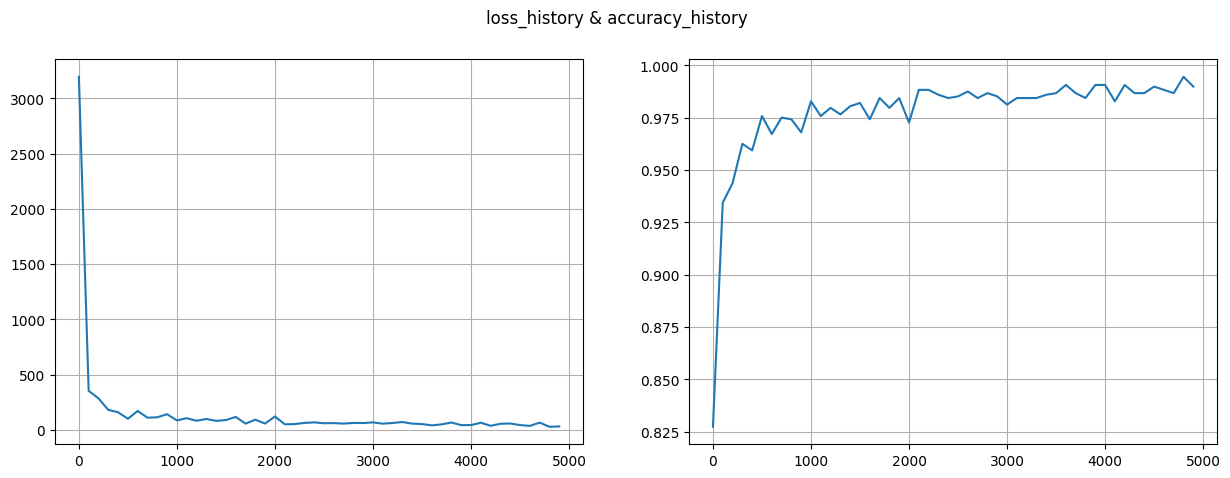

In [52]:
# Виведемо графіки залежності зміни точності та втрат від кроку
def draw_2simple_2d(x1: np.array, y1: np.array, x2: np.array, y2: np.array, suptitle: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x1, y1)
    axs[0].grid()
    axs[1].plot(x1, y2)
    fig.suptitle(suptitle)
    axs[1].grid()


x = np.array([point * cfg.get('display_step') for point in range(len(loss_history))])

draw_2simple_2d(x, loss_history, x, accuracy_history, suptitle='loss_history & accuracy_history')

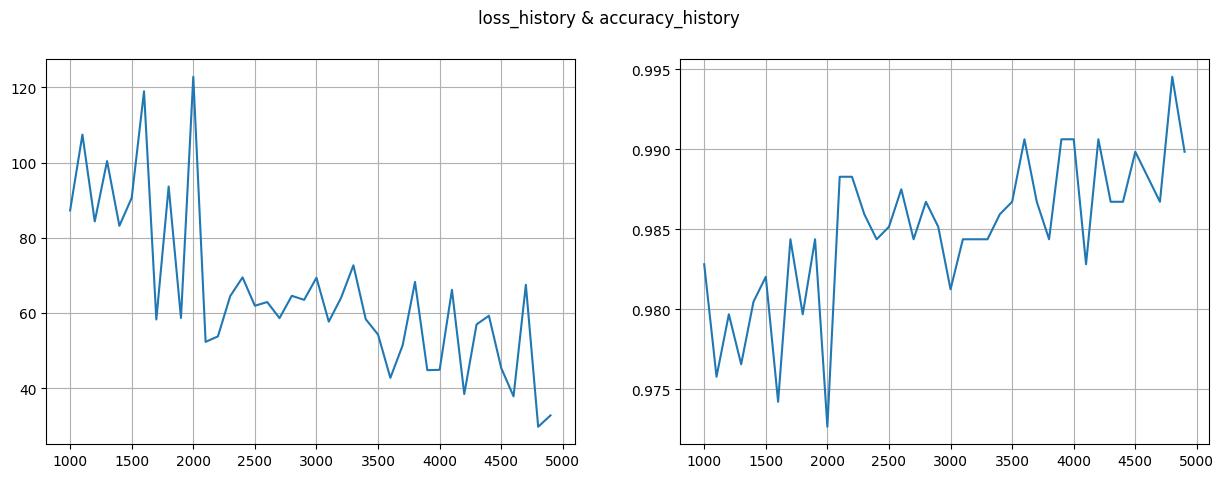

In [53]:
draw_2simple_2d(x[10:], loss_history[10:], x[10:], accuracy_history[10:], suptitle='loss_history & accuracy_history')

In [54]:
# Обчислимо точність навченої нейромережі
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(cfg.get('buffer_size')).batch(1).prefetch(1)


def test_NN(nn, test_data) -> float:
    accuracy_history = []
    for x_t, y_t in test_data.take(1):
        pred = nn(x_t)
        accuracy_history.append(accuracy(pred, y_t))

    return np.mean(accuracy_history)

In [55]:
accuracy_NN = test_NN(neural_net, test_data)
accuracy_NN  # 1.0   0.8   

1.0

In [56]:
# Протестуємо навчену нейромережу на випадкових зображеннях

# 5 from test_
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(cfg.get('buffer_size')).batch(5).prefetch(1)
# and 5 from train
test_data5 = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data5 = test_data5.shuffle(cfg.get('buffer_size')).batch(5).prefetch(1)

accuracy_NN_test1 = test_NN(neural_net, test_data)
accuracy_NN_test2 = test_NN(neural_net, test_data5)
accuracy_NN_test = np.mean([accuracy_NN_test1, accuracy_NN_test2])
accuracy_NN_test  # mean from train and test   0.98

0.98

- https://stackoverflow.com/questions/46923244/how-to-create-image-from-a-list-of-pixel-values-in-python3
- https://pillow.readthedocs.io/en/latest/reference/Image.html
- https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
- https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

In [57]:
from PIL import Image

In [58]:
def print_NN_results(nn, test_data) -> None:
    for x_t, y_t in test_data:
        for sample in range(test_data.get_single_element()[1].numpy().shape[0]):
            img = Image.fromarray((x_t.numpy()[sample].reshape(28, 28) * 255).astype(np.uint8))
            display(img)  # uses buildin display
            pred = nn(x_t).numpy()[sample]
            print(f'True value: {y_t[sample]} => model response: {np.argmax(pred)}\n\n')

In [59]:
print_NN_results(neural_net, test_data.take(1))

True value: 0 => model response: 0




True value: 3 => model response: 3




True value: 5 => model response: 5




True value: 1 => model response: 1




True value: 1 => model response: 1




In [60]:
print_NN_results(neural_net, test_data5.take(1))

True value: 9 => model response: 9




True value: 9 => model response: 9




True value: 7 => model response: 7




True value: 8 => model response: 8




True value: 7 => model response: 7




### __`RESULTS` & `CONCLUSIONS`__

In [61]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

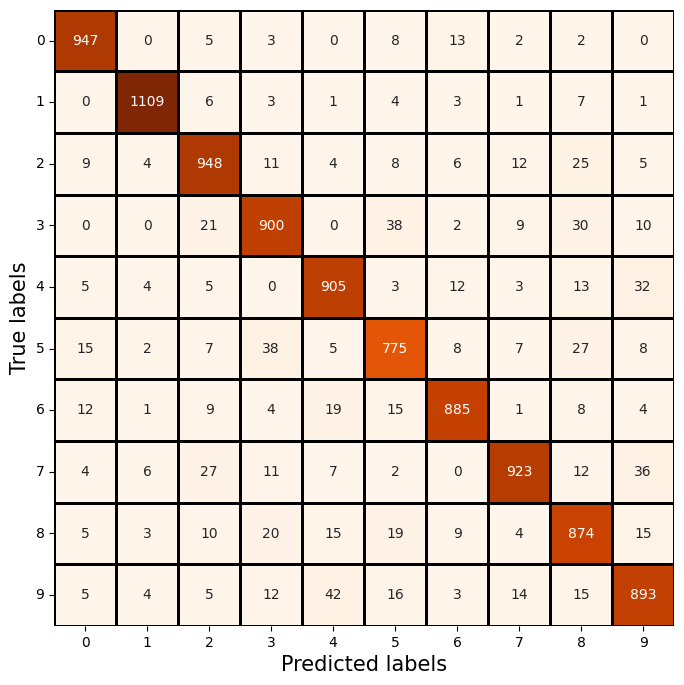

In [62]:
arr = [el for el in range(cfg.get('num_classes'))]
y_pred_test = neural_net(x_test).numpy().argmax(axis=1)


def make_cm(kinds: list, true_results: np.array, predict_results: np.array) -> None:
    cm = confusion_matrix(true_results, predict_results)
    df_confusion_matrix = pd.DataFrame(cm, index=arr, columns=arr)

    plt.figure(figsize=(8, 8))
    sn.heatmap(df_confusion_matrix, fmt='d', annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black')
    plt.xlabel('Predicted labels', fontsize=15)
    plt.xticks(fontsize=10)
    plt.ylabel('True labels', fontsize=15)
    plt.yticks(fontsize=10, rotation=0)


make_cm(arr, y_test, y_pred_test)

Найменше вгадує 5, найбільше - 1. Найбільше плутає 5 з 3, і 4 з 9.

....input-output implement...